# Correlation with gene expression

A key finding from the Bonzanni et al. study is the prediction power of the network model for gene expression profile. Using gene expression data from single-cell microarray experiments of HSPCs(Ramos et al. 2006), their results show a near-linear correlation of averaged gene expression activity from the single-cell profiles to the average gene activity from the modeled HSPC steady states for each of the genes included in the model.
  
Here we perform a similar analysis using the merged models.


In [1]:
model1name = "Bonzanni2013"
model2name = "Krumsiek2011"

In [2]:
# Need to install adjustText if using Colomoto-notebook
!pip install adjustText

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
import pandas as pd
import biolqm
import ginsim
from rpy2.robjects.packages import importr
from rpy2.robjects import IntVector
from rpy2.robjects.vectors import ListVector
from rpy2 import robjects
from rpy2.robjects import conversion
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
boolnet = importr("BoolNet")
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import matplotlib.colors as colors
from scipy.stats import pearsonr
from adjustText import adjust_text

This notebook has been executed using the docker image `colomoto/colomoto-docker:2024-03-01`

In [9]:
home = "persistent/" # home path for Logic Model Merger
merged_and_name = home + "Models/merged_and_" + model1name + "_" + model2name
merged_inhibitor_wins_name = home + "Models/merged_inhibitor_wins_" + model1name + "_" + model2name
merged_or_name = home + "Models/merged_or_" + model1name + "_" + model2name

# load the network
merged_and = boolnet.loadSBML(merged_and_name + ".sbml")
merged_inhibitor_wins = boolnet.loadSBML(merged_inhibitor_wins_name + ".sbml")
merged_or = boolnet.loadSBML(merged_or_name + ".sbml")

In [62]:
# get the asynchronous attractor states
attr_and = boolnet.getAttractors(merged_and)
attr_inhibitor_wins = boolnet.getAttractors(merged_inhibitor_wins)
attr_or = boolnet.getAttractors(merged_or)

for i in range(3):
    attr = [attr_and, attr_inhibitor_wins, attr_or][i]
    df_name = ["attr_merged_and","attr_merged_inhibitor_wins","attr_merged_or"][i]
    
    # Activate the conversion context to use pandas DataFrame
    pandas2ri.activate()
    
    # Access the dataframe stored under the key '1'
    attrr = boolnet.plotAttractors(attr)
    r_df = attrr.rx2('1')
    
    # Use the local converter context to manage the conversion to a numpy array
    with localconverter(robjects.default_converter + pandas2ri.converter):
        np_array = np.array(r_df)
    
    # Extract names from the R dataframe
    row_names = list(r_df.rownames)
    column_names = list(r_df.colnames)
    
    # Create a pandas DataFrame from the numpy array
    df = pd.DataFrame(np_array, index=row_names, columns=column_names)

    # Add the complex/loose attractors
    attrr_comp = boolnet.plotAttractors(attr ,mode = 'graph')
    for i in range(attrr.rx2('1').ncol,len(attrr_comp)):
        attr_array = attrr_comp[i][8][2][0]
        if len(attr_array[0]) == len(df):
            # Loop through each binary string in the array
            for idx, binary_str in enumerate(attr_array):
                # Convert each character in the string to an integer and add as a new column
                column_name = f'Attr{i+1}.{idx + 1}'
                df[column_name] = [int(char) for char in binary_str]
        else:
            print("The number of digits in the binary strings does not match the number of DataFrame rows.")

    df = df.T
    df.index = df.index.str.replace('Attr', 'S')
    df.to_csv(home + 'SimulationResults/' + df_name + "_" + model1name + "_" + model2name + '.csv')

In [10]:
# Model1 results
df1 = pd.read_csv(home + "SimulationResults/attr_" + model1name + ".csv", index_col = 0)
df1.index = df1.index.str.replace('S', 'B')

# Model2 results
df2 = pd.read_csv(home + "SimulationResults/attr_" + model2name + ".csv", index_col = 0)
df2.index = df2.index.str.replace('S', 'K')

# Merged results
df_and = pd.read_csv(home + "SimulationResults/attr_merged_and_" + model1name + "_" + model2name + '.csv', index_col = 0)

df_inhibitor_wins = pd.read_csv(home + "SimulationResults/attr_merged_inhibitor_wins_" + model1name + "_" + model2name + '.csv', index_col = 0)

df_or = pd.read_csv(home + "SimulationResults/attr_merged_or_" + model1name + "_" + model2name + '.csv', index_col = 0)

## Using the Ramos et al. 2006 data

Data are collected from the supplementary material of Ramos et al. 2006.

In [17]:
exp = pd.read_csv(home + "Data/Expression/Expression_Ramos.csv")
exp

,Gene,Expression
0,CBFA2T3,0.166667
1,FLI1,0.416667
2,GATA1,0.000000
3,GATA2,0.333333
4,HHEX,0.416667
5,SPI1,0.333333
6,RUNX1,0.083333
7,TAL1,0.500000
8,SMAD6,0.416667
9,ZFPM1,0.166667


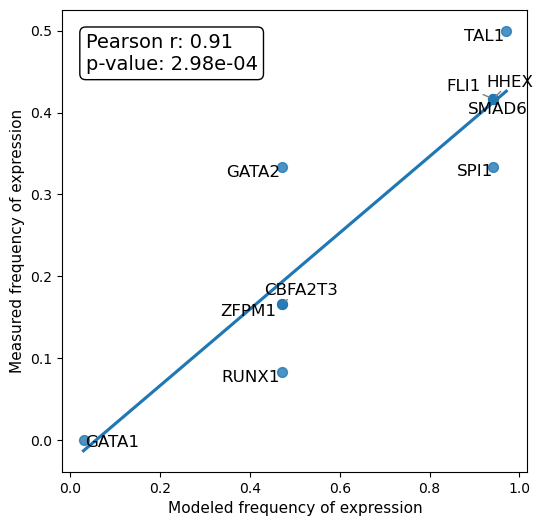

In [13]:
def cor_exp(df1):
    # Calculate frequency of expression for each gene
    frequency = df1.sum() / len(df1)
    
    # Convert frequency to a DataFrame and reset index
    frequency_df = frequency.reset_index()
    frequency_df.columns = ['Gene', 'Frequency']
    
    # Merge with the expression DataFrame
    merged_data = pd.merge(frequency_df, exp, on='Gene', how='inner')
    
    # Compute Pearson correlation and p-value
    correlation, p_value = pearsonr(merged_data['Frequency'], merged_data['Expression'])
    
    # Plotting
    plt.figure(figsize=(6, 6))
    ax = sns.regplot(data=merged_data, x='Frequency', y='Expression', ci=None, scatter_kws={"s": 50})
    plt.xlabel('Modeled frequency of expression',fontsize = 11)
    plt.ylabel('Measured frequency of expression',fontsize = 11)
    
    # Annotate Pearson correlation and p-value
    plt.text(0.05, 0.95, f'Pearson r: {correlation:.2f}\np-value: {p_value:.2e}',
             ha='left', va='top', transform=ax.transAxes, fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    
    # Annotate gene names with adjustText to avoid overlaps
    texts = []
    for i, point in merged_data.iterrows():
        texts.append(ax.text(point['Frequency'], point['Expression'], point['Gene'], ha='right', va='center', fontsize=12))
    
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey'))
    
    plt.show()
cor_exp(df1)

In [65]:
df_or

,ERG,CBFA2T3,RUNX1,SMAD6,HHEX,KLF1,CEBPA,JUN,EGR1,EGR2,NAB1,GFI1,GATA1,GATA2,ZFPM1,TAL1,SPI1,FLI1
S1.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
S2.1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0
S3.1,0,1,0,1,1,0,0,1,1,1,1,0,0,1,1,1,1,1
S3.2,0,1,1,1,1,0,0,1,1,1,1,0,0,1,1,1,1,1
S4.1,0,1,0,1,1,0,1,0,0,0,0,1,0,1,1,1,1,1
S4.2,0,1,1,1,1,0,1,0,0,0,0,1,0,1,1,1,1,1
S5.1,0,1,0,1,1,0,1,1,1,1,1,0,0,1,1,1,1,1
S5.2,0,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,1,1
S6.1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,1,0,1
S6.2,1,0,0,1,1,0,0,0,0,0,0,0,1,1,0,1,1,1


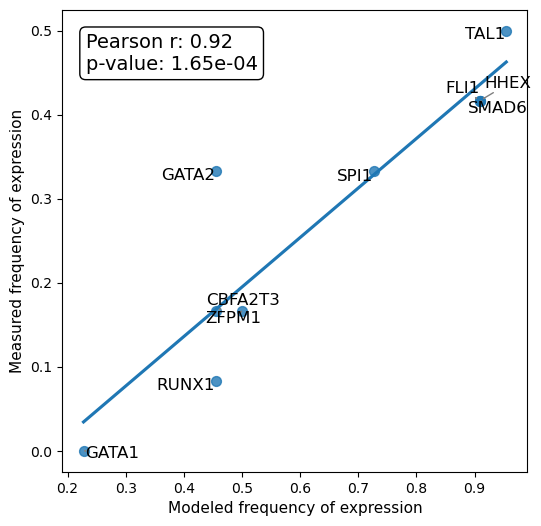

In [14]:
cor_exp(df_or)

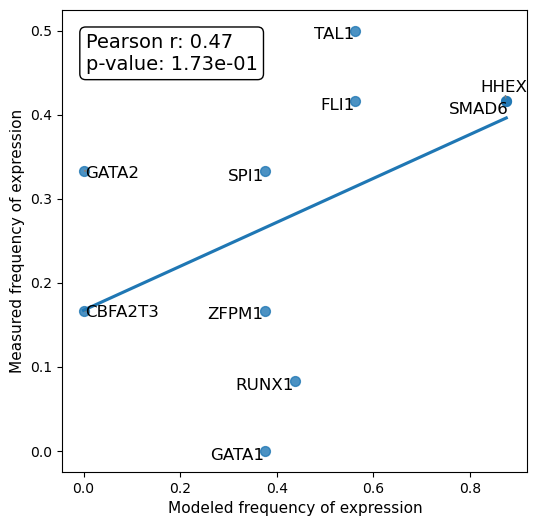

In [15]:
cor_exp(df_inhibitor_wins)

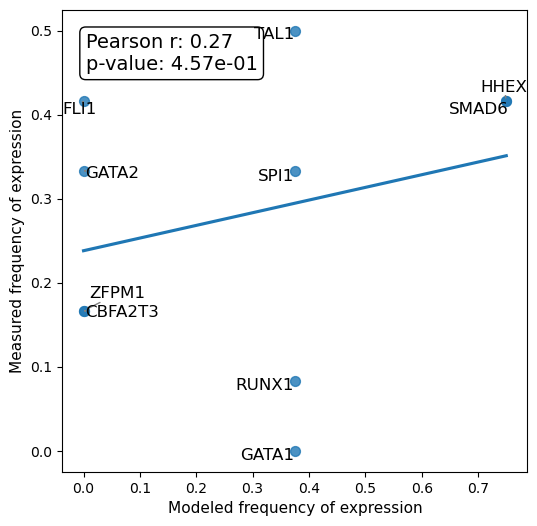

In [16]:
cor_exp(df_and)

Next, we expanded this analysis to include additional genes covered in the Krumsiek et al. model that are not in the Bonzanni et al. model.

In [18]:
# With all the gene expression data
exp_all = pd.read_csv(home + "Data/Expression/Expression_all_Ramos.csv")
exp_all

,Gene,Expression
0,CBFA2T3,0.166667
1,FLI1,0.416667
2,GATA1,0.000000
3,GATA2,0.333333
4,HHEX,0.416667
5,SPI1,0.333333
6,RUNX1,0.083333
7,TAL1,0.500000
8,SMAD6,0.416667
9,ZFPM1,0.166667


In [19]:
def determine_color(label):
    if label in set(df_and.columns) - set(df1.columns):
        return 'orange'
    elif label in set(df_and.columns) - set(df2.columns):
        return 'blue'
    else:
        return 'green'

def cor_all_exp(df1, data):
    # Calculate frequency of expression for each gene in df1
    frequency = df1.sum() / len(df1)
    
    # Convert frequency to a DataFrame and reset index
    frequency_df = frequency.reset_index()
    frequency_df.columns = ['Gene', 'Frequency']
    
    # Merge with the expression DataFrame
    merged_data = pd.merge(frequency_df, data, on='Gene', how='inner')
    
    # Assign colors
    merged_data['Color'] = merged_data['Gene'].apply(determine_color)
    
    # Compute Pearson correlation and p-value
    correlation, p_value = pearsonr(merged_data['Frequency'], merged_data['Expression'])
    
    # Plotting
    plt.figure(figsize=(6, 6))
    ax = sns.regplot(data=merged_data, x='Frequency', y='Expression', ci=None, scatter_kws={"s": 50})
    for i, point in merged_data.iterrows():
        ax.scatter(point['Frequency'], point['Expression'], color=point['Color'], s=50)
    plt.xlabel('Modeled frequency of expression',fontsize = 11)
    plt.ylabel('Measured frequency of expression',fontsize = 11)
    
    # Annotate Pearson correlation and p-value
    plt.text(0.05, 0.95, f'Pearson r: {correlation:.2f}\np-value: {p_value:.2e}',
             ha='left', va='top', transform=ax.transAxes, fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    
    # Detect and manually adjust overlapping annotations
    overlap_threshold = 0.02  
    texts = []
    points_adjusted = set()
    for i, point in merged_data.iterrows():
        for j, other_point in merged_data.iterrows():
            if i != j and abs(point['Frequency'] - other_point['Frequency']) < overlap_threshold and abs(point['Expression'] - other_point['Expression']) < overlap_threshold:
                # Adjust one or both points
                if (i not in points_adjusted) and (j not in points_adjusted):
                    # Adjust current point
                    texts.append(ax.text(point['Frequency'], point['Expression'], point['Gene'], ha='right', va='top', fontsize=10, color=point['Color']))
                    points_adjusted.add(i)
                    # Adjust other point
                    texts.append(ax.text(other_point['Frequency'], other_point['Expression'], other_point['Gene'], ha='left', va='bottom', fontsize=10, color=other_point['Color']))
                    points_adjusted.add(j)
        if i not in points_adjusted:
            texts.append(ax.text(point['Frequency'], point['Expression'], point['Gene'], ha='right', va='center', fontsize=12, color=point['Color']))

    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey'))

    plt.show()

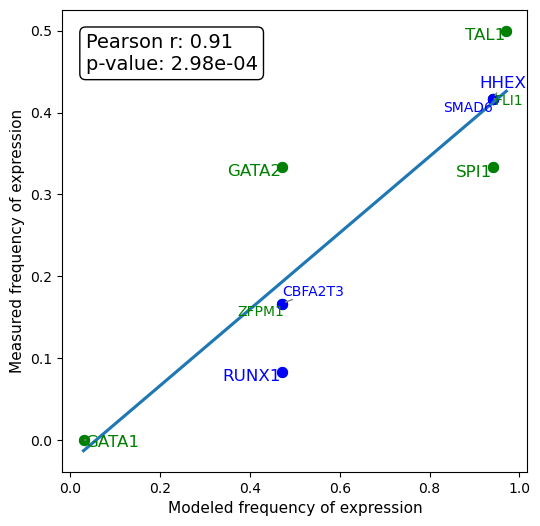

In [20]:
cor_all_exp(df1, exp_all)

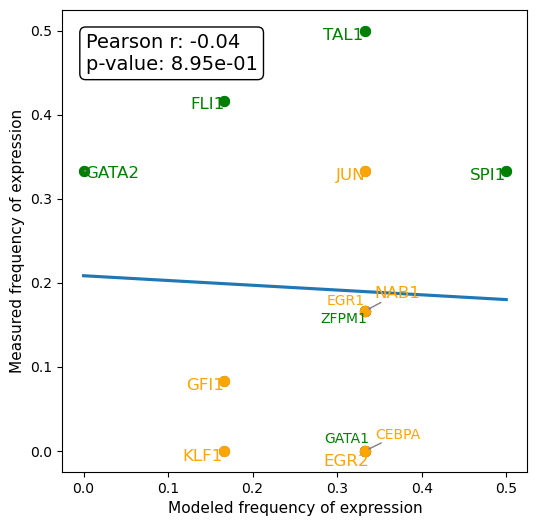

In [21]:
cor_all_exp(df2, exp_all)

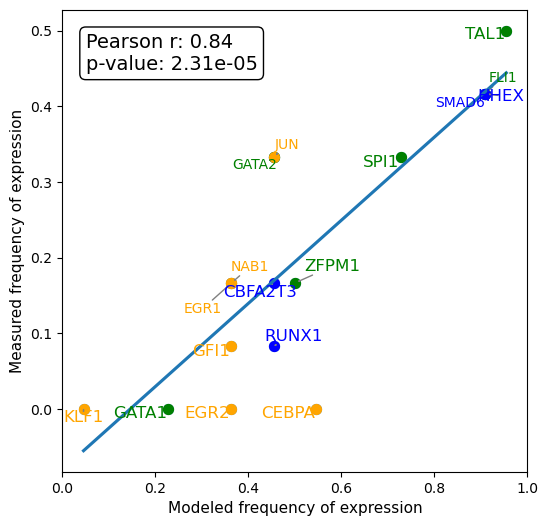

In [22]:
cor_all_exp(df_or, exp_all)

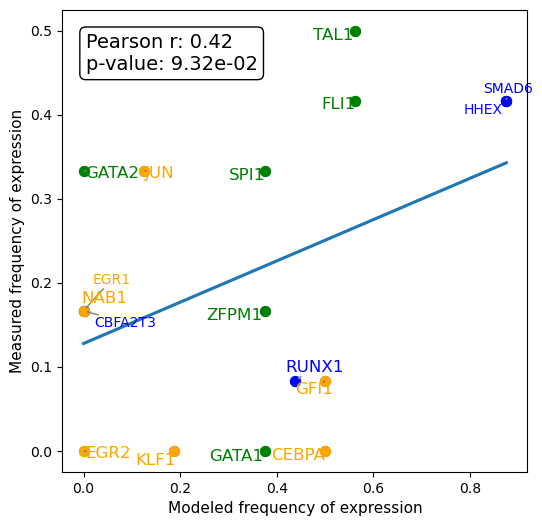

In [23]:
cor_all_exp(df_inhibitor_wins, exp_all)

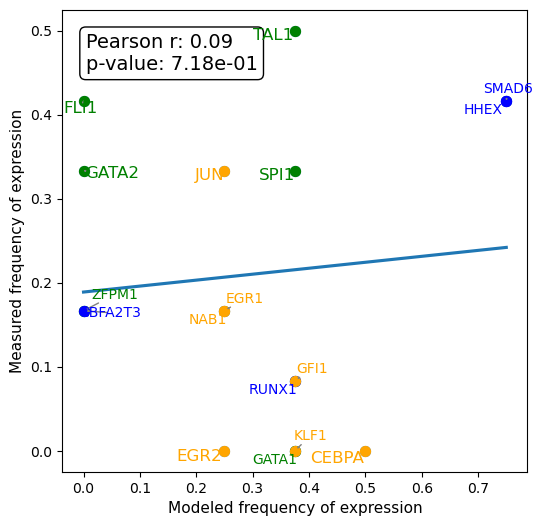

In [24]:
cor_all_exp(df_and, exp_all)

## Distance from experiment status to stable states

In [25]:
exp = pd.read_csv(home + "Data/Expression/Expression_Ramos_num.csv")
exp

,CBFA2T3,HHEX,RUNX1,SMAD6,GATA1,GATA2,TAL1,ZFPM1,SPI1,FLI1,KLF1,CEBPA,JUN,EGR1,EGR2,NAB1,GFI1
0,1,0,0,0,0,1,1,1,0,1,0,0,0,1,0,0,0
1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0
2,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1
8,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [26]:
def find_closest_stable_states(df, exp):
    # Find the common genes
    common_genes = df.columns.intersection(exp.columns)
    
    # Filter both dataframes to include only the common genes
    df_common = df[common_genes]
    exp_common = exp[common_genes]
    
    # Initialize a DataFrame to store the closest stable state and the distance
    results = pd.DataFrame(index=exp.index, columns=['Closest_Stable_State', 'Hamming_Distance'])
    
    # Calculate Hamming distance for each single cell to each stable state
    for cell_index, cell_row in exp_common.iterrows():
        min_distance = np.inf
        closest_state = None
        
        for state_index, state_row in df_common.iterrows():
            distance = np.sum(cell_row != state_row)
            if distance < min_distance:
                min_distance = distance
                closest_state = state_index
        
        results.loc[cell_index] = [closest_state, min_distance]
    
    return results

find_closest_stable_states(df_or, exp)

,Closest_Stable_State,Hamming_Distance
0,S4.2,5
1,S1.1,4
2,S1.1,3
3,S1.1,3
4,S4.2,2
5,S1.1,1
6,S1.1,1
7,S1.1,4
8,S5.1,3
9,S1.1,1


In [27]:
find_closest_stable_states(df_inhibitor_wins, exp)

,Closest_Stable_State,Hamming_Distance
0,S1.1,6
1,S1.1,4
2,S4.1,2
3,S1.1,3
4,S4.4,2
5,S1.1,1
6,S1.1,1
7,S1.1,4
8,S4.1,3
9,S1.1,1


In [28]:
find_closest_stable_states(df_and, exp)

,Closest_Stable_State,Hamming_Distance
0,S1.1,6
1,S1.1,4
2,S1.1,3
3,S1.1,3
4,S6.1,3
5,S1.1,1
6,S1.1,1
7,S1.1,4
8,S6.1,2
9,S1.1,1


## Using the Biasco et al. 2018 data.

We have performed a similar task using another HSC scRNA-seq data from Biasco et al. 2019, [GSM3305359](https://www-ncbi-nlm-nih-gov.offcampus.lib.washington.edu/geo/query/acc.cgi?acc=GSM3305359). 

In [ ]:
file_path = home + 'Data/Expression/GSM3305359_HSC.raw_counts.tsv.gz'

# Read the file into a pandas DataFrame
df = pd.read_csv(file_path, sep='\t', index_col=0)

# Reset the index to convert the gene names to a column
df.reset_index(inplace=True)

# Rename the index column to 'Gene'
df.rename(columns={'Barcode': 'Gene'}, inplace=True)

# Convert the DataFrame from a wide format to a long format
df_long = df.melt(id_vars=['Gene'], var_name='Barcode', value_name='Count')

# Filter the DataFrame to only include rows where the Count is greater than 0
df_filtered = df_long[df_long['Count'] > 0]

# Group by the gene and count the number of non-zero expressions
df_expression_counts = df_filtered.groupby('Gene').size().reset_index(name='NonZeroCount')

# Calculate the frequency of expression
total_cells = df.shape[1] - 1  # Subtracting 1 because the first column is 'Gene'
df_expression_counts['Expression'] = df_expression_counts['NonZeroCount'] / total_cells

# Select only the Gene and ExpressionFrequency columns
df_expression_frequency = df_expression_counts[['Gene', 'Expression']]

# Display the resulting DataFrame
print(df_expression_frequency)

df_expression_frequency.to_csv(home + 'Data/Expression/expression_frequency_Pellin.csv', index=False)

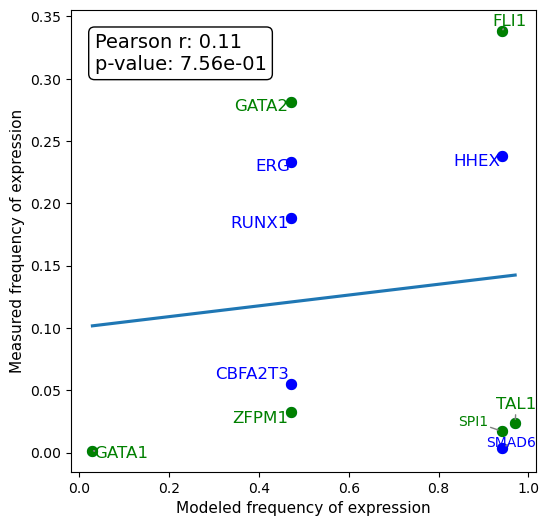

In [30]:
cor_all_exp(df1, df_expression_frequency)

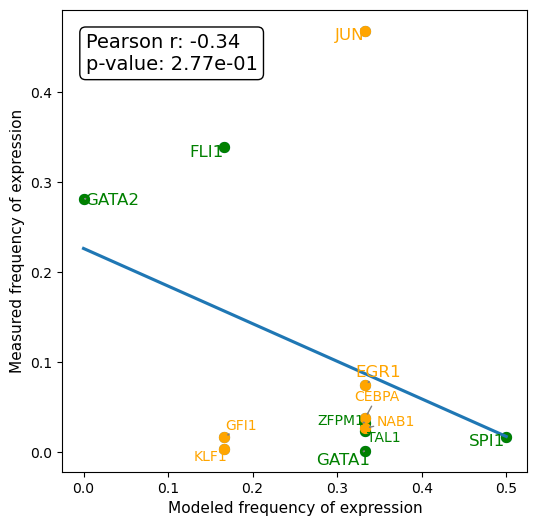

In [31]:
cor_all_exp(df2, df_expression_frequency)

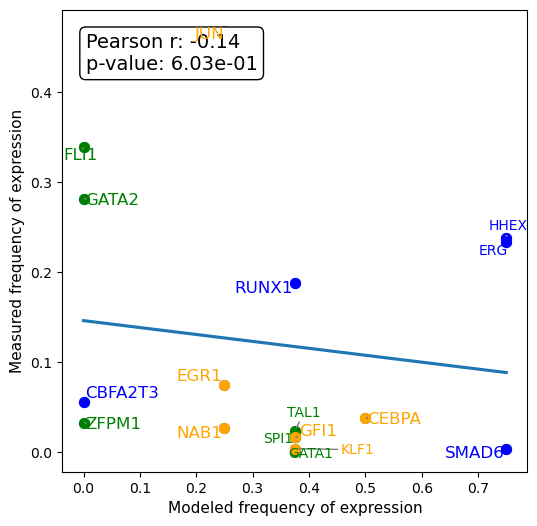

In [32]:
cor_all_exp(df_and, df_expression_frequency)

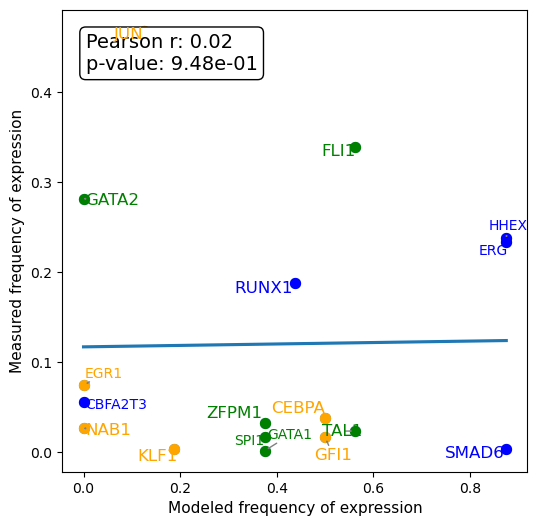

In [33]:
cor_all_exp(df_inhibitor_wins, df_expression_frequency)

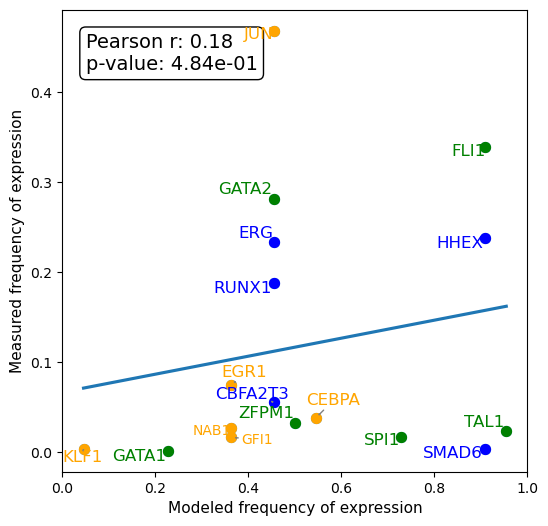

In [34]:
cor_all_exp(df_or, df_expression_frequency)

## Using the Diamanti et al. 2015 data

And another HSC scRNA-seq data from Diamanti et al. 2015, [GSE61533](https://www-ncbi-nlm-nih-gov.offcampus.lib.washington.edu/geo/query/acc.cgi?acc=GSE61533). 

In [35]:
!pip install xlrd

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 6.8 MB/s eta 0:00:00


In [36]:
file_path = home + 'Data/Expression/GSE61533_HTSEQ_count_results.xls'

# Read the file into a pandas DataFrame
df = pd.read_excel(file_path, index_col=0)

# Ensure all data is numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Reset the index to convert the gene names to a column
df.reset_index(inplace=True)

# Rename the index column to 'Gene'
df.rename(columns={'ID': 'Gene'}, inplace=True)
df['Gene'] = df['Gene'].str.upper()

# Filter the DataFrame to include only the genes in the merged model
df_filtered_genes = df[df['Gene'].isin(df_and.columns)]


In [37]:
# Calculate the 5% quantile for each gene considering only non-zero values
quantile_5_percent = df_filtered_genes.set_index('Gene').apply(lambda x: x[x > 0].quantile(0.05), axis=1)

# Convert the DataFrame from a wide format to a long format
df_long = df_filtered_genes.melt(id_vars=['Gene'], var_name='Barcode', value_name='Count')

# Merge the quantile data back into the long DataFrame
df_long = df_long.merge(quantile_5_percent.reset_index(), on='Gene')

# Rename the quantile column for clarity
df_long.rename(columns={0: 'Quantile_5'}, inplace=True)

# Filter the DataFrame to only include rows where the Count is greater than the 5% quantile
df_long['Expressed'] = df_long['Count'] > df_long['Quantile_5']

# Group by the gene and count the number of expressed cells
df_expression_counts = df_long.groupby('Gene')['Expressed'].sum().reset_index(name='ExpressedCount')

# Calculate the frequency of expression
total_cells = df_filtered_genes.shape[1] - 1  # Subtracting 1 because the first column is 'Gene'
df_expression_counts['Expression'] = df_expression_counts['ExpressedCount'] / total_cells

# Select only the Gene and ExpressionFrequency columns
df_expression_frequency = df_expression_counts[['Gene', 'Expression']]

# Display the resulting DataFrame
print(df_expression_frequency)


       Gene  Expression
0   CBFA2T3    0.895833
1     CEBPA    0.041667
2      EGR1    0.802083
3      EGR2    0.000000
4       ERG    0.895833
5      FLI1    0.906250
6     GATA1    0.062500
7     GATA2    0.947917
8      GFI1    0.145833
9      HHEX    0.895833
10      JUN    0.906250
11     KLF1    0.041667
12     NAB1    0.447917
13    RUNX1    0.895833
14    SMAD6    0.052083
15     TAL1    0.739583
16    ZFPM1    0.614583


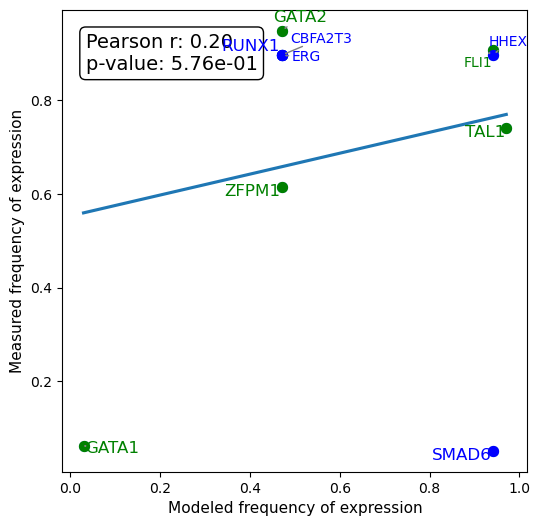

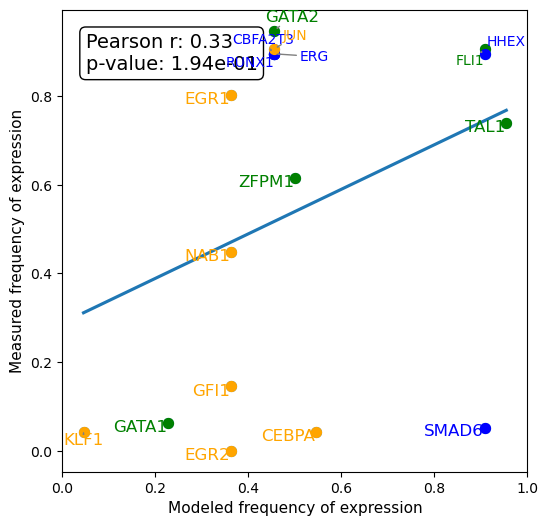

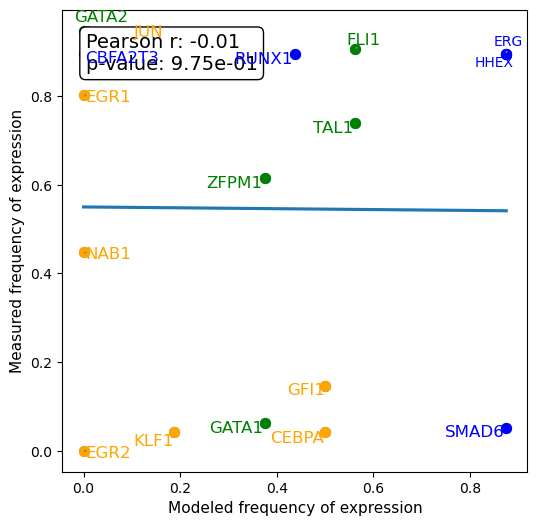

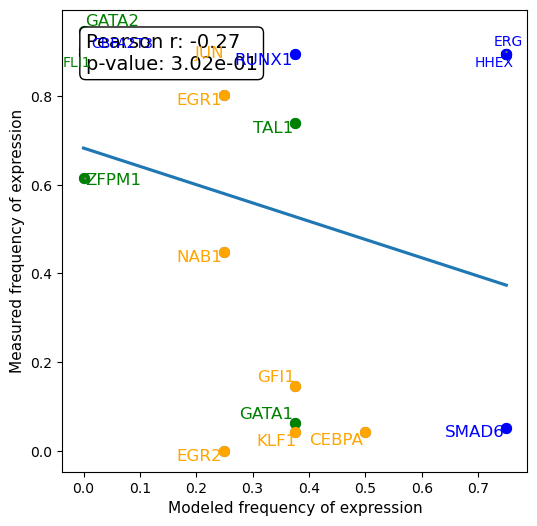

In [39]:
cor_all_exp(df1, df_expression_frequency)
cor_all_exp(df_or, df_expression_frequency)
cor_all_exp(df_inhibitor_wins, df_expression_frequency)
cor_all_exp(df_and, df_expression_frequency)